## Proof of Concept: Abnormal Activity Detection
In **TCO19 Shell GameChanger Challenge**, we are presented with the opportunity to detect abnormal activity of a production subsea system.  

Our team decided choose the simplest approach to the problem; a binary classification problem - **Normal vs. Abnormal**     
In this approach, we hope to design a non-propiertary, elegant solution to the problem.    
Below is our proof of concept that walks through how we encode, feature select, model and validate our **Dual Model System**.   

### Dual-Model System
To fulfill the business needs and to make a stable model we decided on a **Dual-Model System**.  
1) The first model is the **"Warning" Model** that is trained to be sensitive to any abnormal activity and will predict the onset of any abnormal event.  
2) The second model is the **"Critical" Model** and will be trained strictly to detect and identify when we are in the abnormal phase.  

By having this dual model scheme we hope to have a robust **anomaly detector** that can work in tandem with a great **anomaly predictor**. This dual system can enable us to operational act in the appropriate manner. Such as during the **"Warning" Phase** we can take the necessary precautions and react with moderate interventation. However if we are in the **"Critical" Phase**, immediate act must be taken and severe measures might have to be implement. 

### Loading Libraries

In [1]:
# if this is the first time using an Anaconda environment.  
#Please uncomment the below line to pip install xgboost.

#!pip install xgboost

In [2]:
#Standard python libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#User Utils for Plotting and Scoring
from utils2 import plot_pred, metric_report,event_encoder,time_frame,feature_selection,add_outcome,return_outcome

### Importing Data

In [3]:
train_df = pd.read_csv('training.csv',parse_dates=['EventTime'],index_col='EventTime')
test_df  = pd.read_csv('validation.csv',parse_dates=['EventTime'],index_col='EventTime')

### Defining the Abnormal Events
For our binary classification problem, we need to define our abnormal events and utilize this information to create this binary target (**Normal** = 0 ; **Abnormal** =1)  
This binary encoding will be utilize for both training and validating the model.  
**Note:** Model was trained with a 30 min lag window on the train data to better capture the transitional period.

In [4]:
#Defining each event
Event_1 = ['2016-05-22 20:42:00','2016-05-24 16:00:00']
Event_2 = ['2016-07-17 02:30:00','2016-07-19 08:00:00']
Event_3 = ['2016-07-29 10:13:00','2016-08-01 16:00:00']
Event_4 = ['2017-08-18 14:18:00','2017-08-23 12:00:00']
Event_5 = ['2017-09-20 05:35:00','2017-09-27 12:00:00']
Event_6 = ['2017-11-04 11:45:00','2017-11-13 06:00:00']
Event_7 = ['2017-11-29 11:27:00','2017-12-01 17:00:00']
Event_8 = ['2018-02-08 04:19:00','2018-02-10 11:40:00']
#Conversion of Events to datetime
Events_train = pd.to_datetime(Event_1+Event_2+Event_3+Event_4+Event_5+Event_6)
Events_test = pd.to_datetime(Event_7+Event_8)
# Encoding the events into the dataset
train_df=event_encoder(Events_train,train_df)
test_df =event_encoder(Events_test,test_df)

## Part 1: "Warning Model" 


### Part 1: Feature Selection
Through various methods of feature selections such as recursive feature elimination, feature importance, Leave-One-Out etc., we were able to narrow down the top variables that could detect the abnormal event.

In [5]:
X_train,y_train= feature_selection(train_df,n=25)
X_test, y_test = feature_selection(test_df,n=25)

### Part 1: XGBoost Predictor Model
Utilizing a XGB Model trained to be sensitive to any abrnomal behavior. We chosen XGBoost as the base of our model as it is a very powerful algorithm but can be examine to see feature importances and interactions. Thus, we are able to intrepret how the variables are utilize and interact in the model.

In [6]:
Warning_model = pickle.load(open("warning_model.pickle.dat", "rb"))

### Scoring and Validation
Per dataset, we will evaluate the model on both business needs and the correct metrics for a classifer. The metrics are as follows:  
- **ROC-AUC:** ability to rank between the two classes of Normal or Abnormal  
- **Balanced Accuracy:** accuracy score accounting for imabalanced classes that is defined as the average of recall obtained on each class  
- **Confusion Matrix:**  
    - Displays the # of True Positives, True Negatives, False Positives and False Negatives  
    - Format is as follows:  
    [[True Negative  False Positive]  
     [False Negative True Positive]]  
- **Classification Report:**  
    - Overall classification metric scorecard.  
    - Display precision, recall and f1-score.      
- **Prediction vs Actuals Graphs**
  - Plot of the model predictions represented as *Normal* = 0 and *Abnormal* = 1 over the dataset period compared to the Actual Values defined by the Event Times.
  - Orange = Model Predictions  
  - Blue = True Values (**Note: We just scaled the Actual values to 2 for better graphical visiblity**)    
- **Feature Importances**    
    - Bar chart explaining what variables are important to the model and the magnitude of their importance to the model as well.    
- **Times Detected**  
    - Shows beginning and end timestamps of each event.   
    - In addition, shows the time that the model predicts that the abnormal event is starting.

=============== TRAIN ===============
          ROC AUC score: 0.9999634942186785
Balanced Accuracy score: 0.992500648929052

	Confusion Matrix
 [[778348    389]
 [   589  40034]]


	TRAIN Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    778737
           1       0.99      0.99      0.99     40623

    accuracy                           1.00    819360
   macro avg       0.99      0.99      0.99    819360
weighted avg       1.00      1.00      1.00    819360




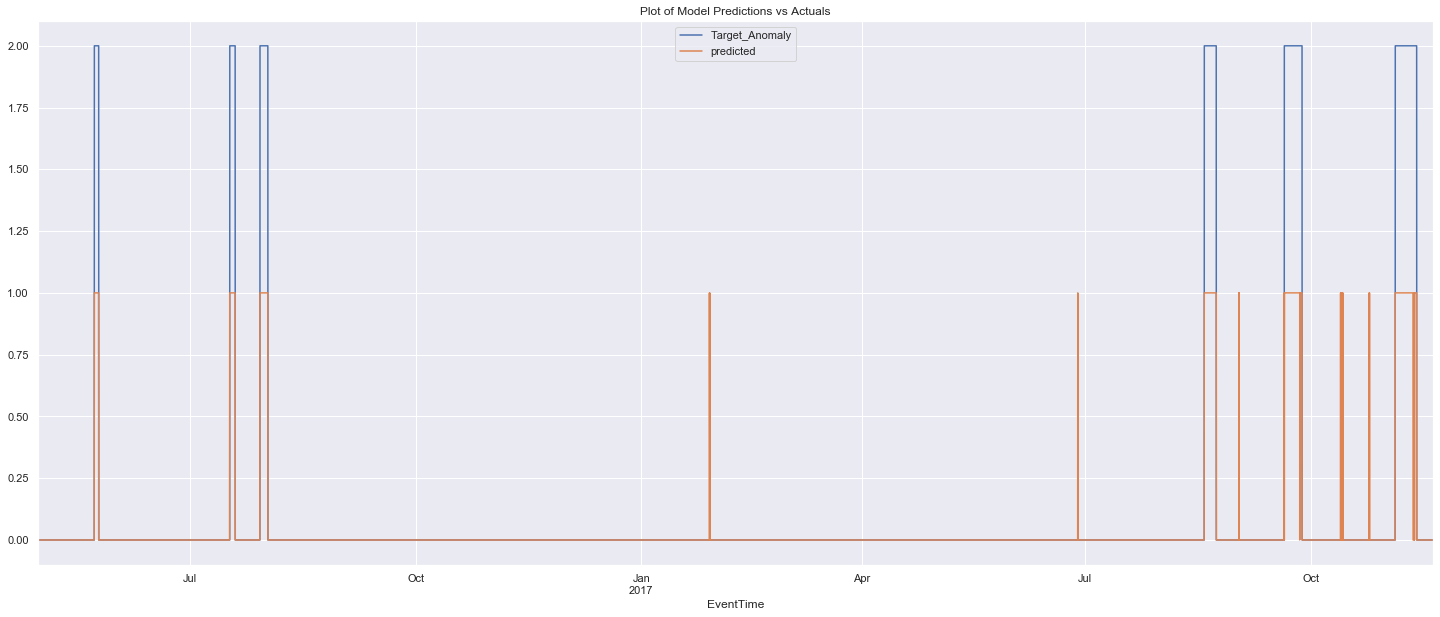

=============== TEST ===============
          ROC AUC score: 0.9718301131506448
Balanced Accuracy score: 0.9669919722753655

	Confusion Matrix
 [[116057   1247]
 [   362   6174]]


	TEST Classification Report
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    117304
           1       0.83      0.94      0.88      6536

    accuracy                           0.99    123840
   macro avg       0.91      0.97      0.94    123840
weighted avg       0.99      0.99      0.99    123840




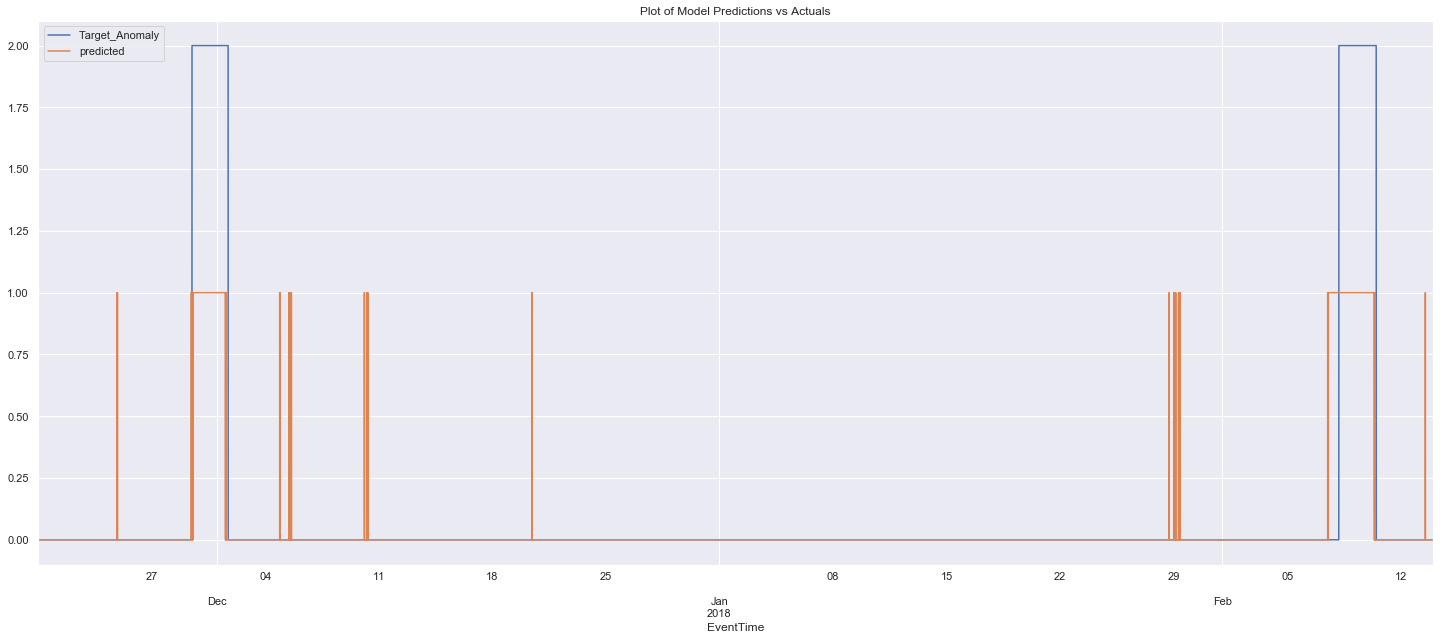

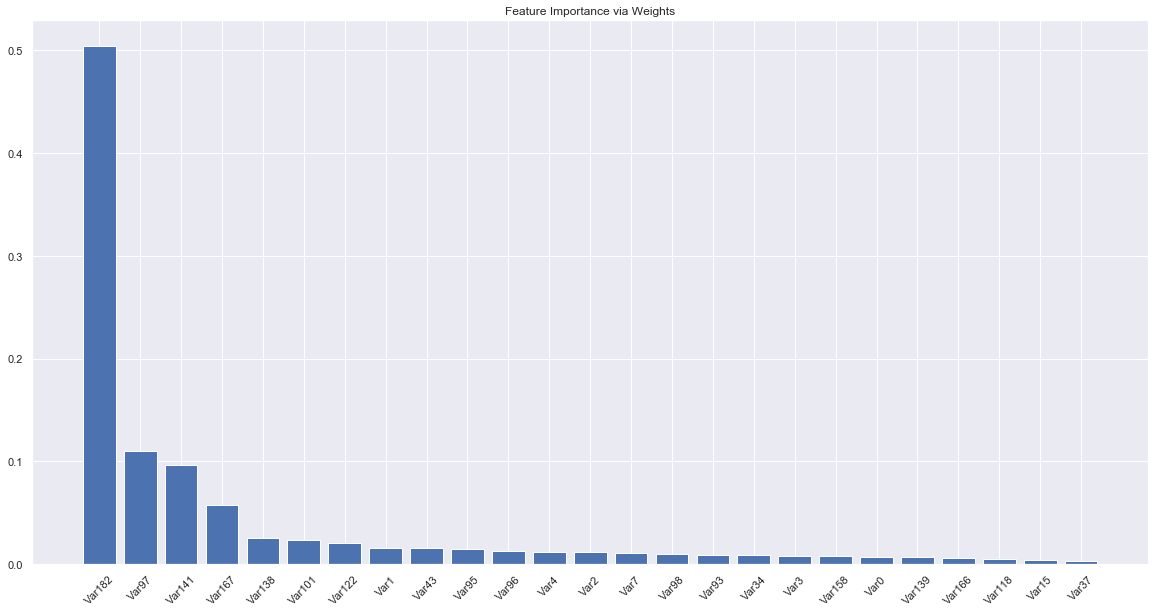

------------------- Time Detected -------------------
Showing the time that the warning model predicts that the abnormal event is starting
-------------------------- Event 1 --------------------------
 Predicted Start Anomaly Time: 2016-05-22 20:12:00.
   Predicted End Anomaly Time: 2016-05-24 15:58:00.
            Detected early by: 0 days 00:30:00

-------------------------- Event 2 --------------------------
 Predicted Start Anomaly Time: 2016-07-17 02:02:00.
   Predicted End Anomaly Time: 2016-07-19 07:59:00.
            Detected early by: 0 days 00:28:00

-------------------------- Event 3 --------------------------
 Predicted Start Anomaly Time: 2016-07-29 09:43:00.
   Predicted End Anomaly Time: 2016-08-01 15:59:00.
            Detected early by: 0 days 00:30:00

-------------------------- Event 4 --------------------------
 Predicted Start Anomaly Time: 2017-08-18 13:45:00.
   Predicted End Anomaly Time: 2017-08-23 11:59:00.
            Detected early by: 0 days 00:33:00

-----

In [7]:
#Parameters
thresh_val=0.45
modelx = Warning_model

#Metric Reports
metric_report(modelx, X_train,y_train, thresh=thresh_val,name= "TRAIN")
metric_report(modelx, X_test , y_test, thresh=thresh_val,name= "TEST")

#Plotting out the weights of the model to see importance 
Start = 0
End = 30
indices = np.argsort(np.abs(modelx.feature_importances_))[::-1]
plt.figure(figsize=(20,10))
plt.title("Feature Importance via Weights")
plt.bar(X_train.columns[indices][Start:End], np.abs(modelx.feature_importances_)[indices][Start:End])
plt.xticks(X_train.columns[indices][Start:End], rotation = 45)
plt.show()

#Finding Time Frame
#Train Events
print('------------------- Time Detected -------------------')
print('Showing the time that the warning model predicts that the abnormal event is starting')
time_frame(modelx,X_train,Event_1,num=1,thresh=thresh_val)
time_frame(modelx,X_train,Event_2,num=2,thresh=thresh_val)
time_frame(modelx,X_train,Event_3,num=3,thresh=thresh_val)
time_frame(modelx,X_train,Event_4,num=4,thresh=thresh_val)
time_frame(modelx,X_train,Event_5,num=5,thresh=thresh_val)
time_frame(modelx,X_train,Event_6,num=6,thresh=thresh_val)
#Test Events
time_frame(modelx,X_test,Event_7,num=7,thresh=thresh_val)
time_frame(modelx,X_test,Event_8,num=8,early=3000,thresh=thresh_val)

## Part 2: "Critical Model"

### Part 2: Feature Selection
Use similar process as above model for feature selection.

In [8]:
X_train2,y_train2= feature_selection(train_df,n=25,Target_included=False)
X_test2, y_test2 = feature_selection(test_df,n=25,Target_included=False)

### Part 2: XGBoost Detector Model
Utilizing a XGB Model also for 2nd model. Slightly tuned and adheres more to abrnomal phasing.

In [9]:
Critical_model = pickle.load(open("Critical_model.pickle.dat", "rb"))

=============== TRAIN ===============
          ROC AUC score: 0.9999634942186785
Balanced Accuracy score: 0.9897788914302685

	Confusion Matrix
 [[778518    219]
 [   819  39804]]


	TRAIN Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    778737
           1       0.99      0.98      0.99     40623

    accuracy                           1.00    819360
   macro avg       1.00      0.99      0.99    819360
weighted avg       1.00      1.00      1.00    819360




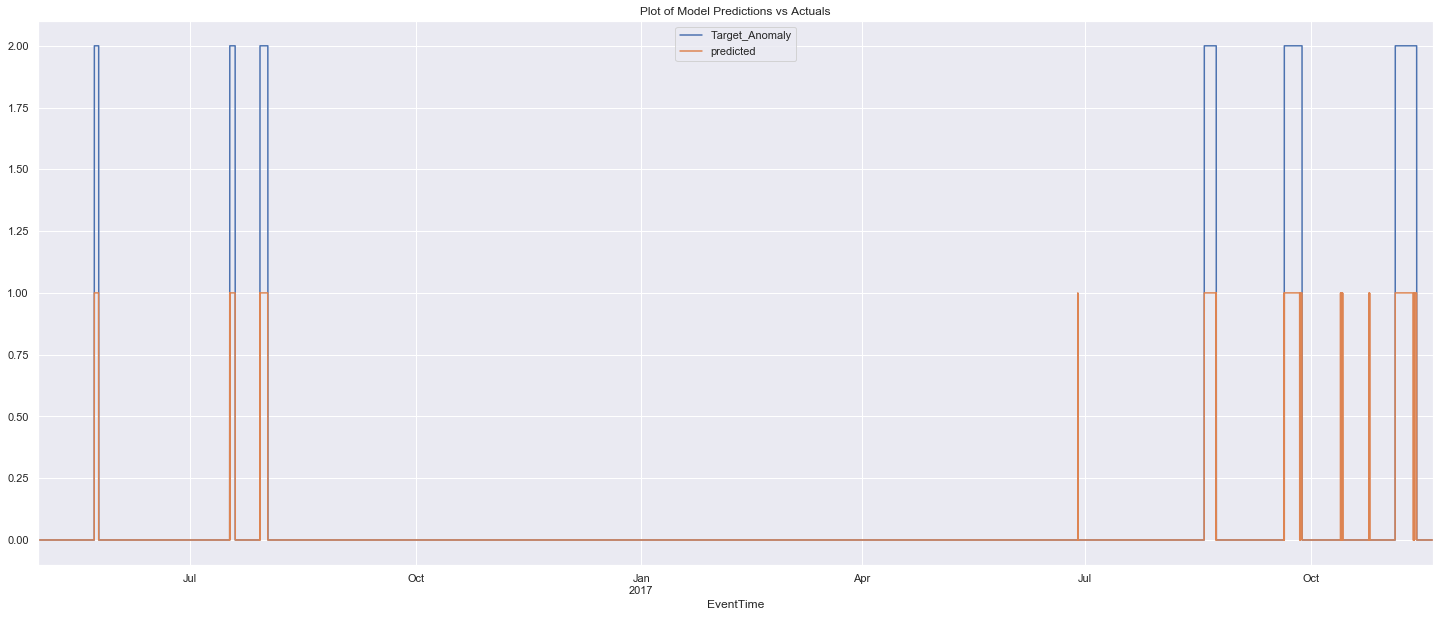

=============== TEST ===============
          ROC AUC score: 0.9718301131506448
Balanced Accuracy score: 0.9629897755539363

	Confusion Matrix
 [[117182    122]
 [   477   6059]]


	TEST Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    117304
           1       0.98      0.93      0.95      6536

    accuracy                           1.00    123840
   macro avg       0.99      0.96      0.98    123840
weighted avg       1.00      1.00      1.00    123840




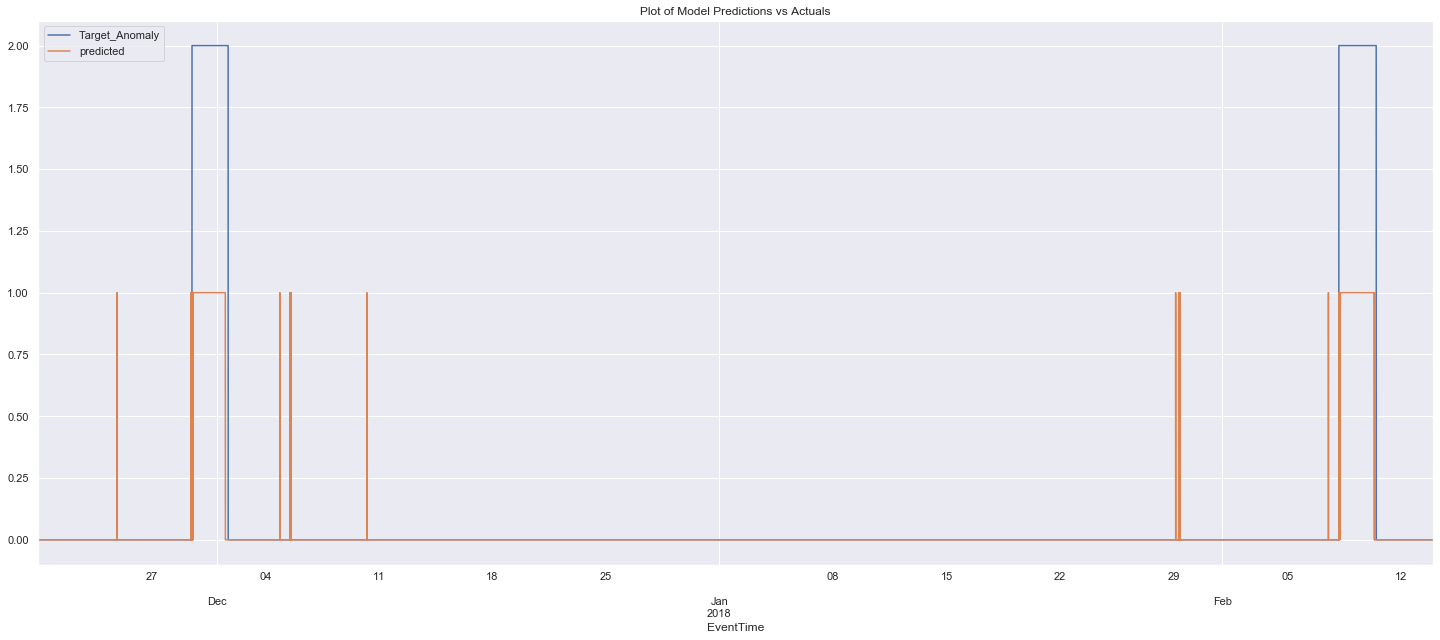

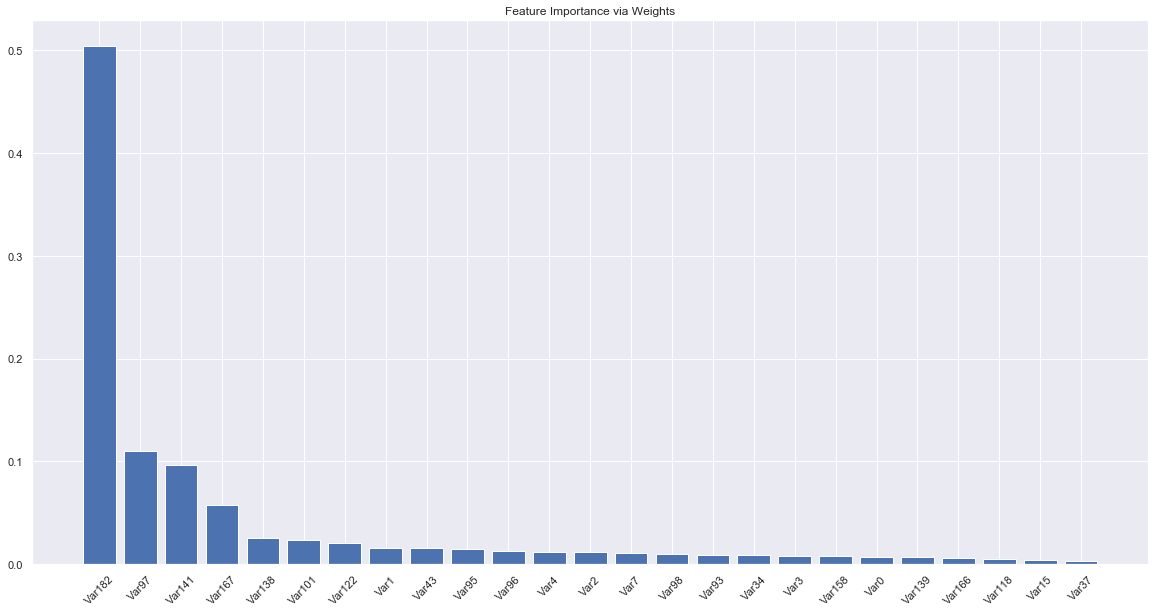

------------------- Time Detected -------------------
Showing the time that the critical model predicts that the abnormal event is starting
-------------------------- Event 1 --------------------------
 Predicted Start Anomaly Time: 2016-05-22 20:12:00.
   Predicted End Anomaly Time: 2016-05-24 15:58:00.
            Detected early by: 0 days 00:30:00

-------------------------- Event 2 --------------------------
 Predicted Start Anomaly Time: 2016-07-17 02:03:00.
   Predicted End Anomaly Time: 2016-07-19 07:59:00.
            Detected early by: 0 days 00:27:00

-------------------------- Event 3 --------------------------
 Predicted Start Anomaly Time: 2016-07-29 09:44:00.
   Predicted End Anomaly Time: 2016-08-01 15:59:00.
            Detected early by: 0 days 00:29:00

-------------------------- Event 4 --------------------------
 Predicted Start Anomaly Time: 2017-08-18 13:48:00.
   Predicted End Anomaly Time: 2017-08-23 11:58:00.
            Detected early by: 0 days 00:30:00

----

In [10]:
thresh_val=0.8
modelx = Critical_model

#Metric Reports
metric_report(modelx, X_train2,y_train2, thresh=thresh_val,name= "TRAIN")
metric_report(modelx, X_test2 , y_test2, thresh=thresh_val,name= "TEST")

#Plotting out the weights of the model to see importance 
Start = 0
End = 30
indices = np.argsort(np.abs(modelx.feature_importances_))[::-1]
plt.figure(figsize=(20,10))
plt.title("Feature Importance via Weights")
plt.bar(X_train2.columns[indices][Start:End], np.abs(modelx.feature_importances_)[indices][Start:End])
plt.xticks(X_train2.columns[indices][Start:End], rotation = 45)
plt.show()

#Finding Time Frame
#Train Events
print('------------------- Time Detected -------------------')
print('Showing the time that the critical model predicts that the abnormal event is starting')
time_frame(modelx,X_train2,Event_1,num=1,thresh=thresh_val)
time_frame(modelx,X_train2,Event_2,num=2,thresh=thresh_val)
time_frame(modelx,X_train2,Event_3,num=3,thresh=thresh_val)
time_frame(modelx,X_train2,Event_4,num=4,thresh=thresh_val)
time_frame(modelx,X_train2,Event_5,num=5,thresh=thresh_val)
time_frame(modelx,X_train2,Event_6,num=6,thresh=thresh_val)
#Test Events
time_frame(modelx,X_test2,Event_7,num=7,thresh=thresh_val)
time_frame(modelx,X_test2,Event_8,num=8,early=360,thresh=thresh_val)

### Summary
- Overall, both models are very stable on the dataset as a classifier with a **ROC AUC score = 0.99**.
- The **"Warning" Model** was able to predict **1 hr and 32 minutes** ahead of the abnormal event for Event 7 and **16 hours and 27 minutes** for Event 8.  
- The **"Critical" Model** was able to more strictly adhere to the abnormal phases and reduce the amount of false positives shown in "Warning" Model. Out of **123,840** observations, the "Critical" Model classify only **122** observations as False Positives versus the **1247** False Postives from the "Warning" Model. 
- Together, they cooperatively work to predict and detect anomalous behavior in the system.

Given more time we can furthur improve various aspects of the models such as:

- **Severity Analysis**: analyze the duration of various event to furthur improve accuracy
- **Fine tuning**: adjust to the parameters and better analysis of the transitional period. We believe it might be a bit overfit since we have a small dataset. More data can help improve this.
- **Model Simplification** - XGBoost model could be replaced with a cheaper model such as Logisitic Regression if we build in the feature interactions.


In [13]:
X_train_warning =add_outcome(Warning_model,X_train,thresh=0.45)
X_train_critical=add_outcome(Critical_model,X_train2,thresh=0.8)
X_train_warning.rename(columns={'y_outcome':'y_warning'},inplace=True)
X_train_critical.rename(columns={'y_outcome':'y_critical'},inplace=True)
X_warning = X_train_warning['y_warning']
X_critical=X_train_critical['y_critical']
POC_train_results = pd.merge(X_warning,X_critical,left_index=True,right_index=True)

In [41]:
print(POC_train_results.shape)
print(POC_train_results['y_warning'].value_counts())
print(POC_train_results['y_critical'].value_counts())

(819360, 2)
0    778937
1     40423
Name: y_warning, dtype: int64
0    779337
1     40023
Name: y_critical, dtype: int64


In [47]:
Final_train_results=POC_train_results['y_warning']

In [51]:
Final_train_results.to_csv('POC_train_results.csv')

In [44]:
X_test_warning =add_outcome(Warning_model,X_test,thresh=0.45)
X_test_critical=add_outcome(Critical_model,X_test2,thresh=0.8)
X_test_warning.rename(columns={'y_outcome':'y_warning'},inplace=True)
X_test_critical.rename(columns={'y_outcome':'y_critical'},inplace=True)
X_warning2 = X_test_warning['y_warning']
X_critical2=X_test_critical['y_critical']
POC_test_results = pd.merge(X_warning2,X_critical2,left_index=True,right_index=True)

In [45]:
print(POC_test_results.shape)
print(POC_test_results['y_warning'].value_counts())
print(POC_test_results['y_critical'].value_counts())

(123840, 2)
0    116419
1      7421
Name: y_warning, dtype: int64
0    117659
1      6181
Name: y_critical, dtype: int64


In [52]:
Final_test_results=POC_test_results['y_warning']

In [55]:
Final_test_results.to_csv('POC_test_results.csv')